# LFR CPU Powerdown effect on power supply emissions 

## Observed Problem

During MEB EMC test tests a 96Hz plus its harmonics was found. This polution has been tracked down to LFR. After some investigations this has been correlated to the LFR **S**pactral **M**atrices computation module which produce an interuption after each SM. 


At F0(24576Hz) LFR compute a FFT of 256 points each $\frac{256}{24576}=10.416667ms \Leftrightarrow 96Hz$


Since LFR CPU and **F**light **S**oft**W**are uses powerdown feature, the CPU is sleeping most of the time and woken up at 96Hz by SM module which produces a peak in power consuption.

## Test goal

The aim of this test is to validate if a software solution can reduce or remove this pertubation. In this test, the solution tested is to create a new task with the lowest priority to keep CPU busy and avoid entering powerdown mode.


![setup](./ressources/Setup.png)

## Instrument list
- SPW brick: StarDundee ** USB SPW brick MK1 **
- LFR PSU: Custom power supply
- LFR EGSE: Custom waveform generator
- I probe: Tektronix **AM503A** + **A6302**
- USB Scope: DreamSourceLab **DSLogic Oscillosocpe**
- LFR EQM2

[Modified LFR FSW](https://hephaistos.lpp.polytechnique.fr/rhodecode/HG_REPOSITORIES/LPP/INSTRUMENTATION/USERS/JEANDET/LFR_FSW/changeset/fc82b08705ba9931880e4e57a76b1bb1ffa1e28e)

## Test Procedure


1. Connect all equipment as described in setup
2. Take pictures of the setup
3. Calibrate I probes
4. Start LFR EGSE
5. Power ON LFR /
6. **check power consumption**
7. Boot LFR with **FSW 3.2.0.15**
8. Record current and save it as FSW_3.2.0.15_STANDBY.csv
9. Enter **Normal** mode
10. Record current and save it as FSW_3.2.0.15_NORMAL.csv
11. Enter **BURST** mode
12. Record current and save it as FSW_3.2.0.15_BURST.csv
13. Enter **SBM1** mode
14. Record current and save it as FSW_3.2.0.15_SBM1.csv
15. Enter **SBM2** mode
16. Record current and save it as FSW_3.2.0.15_SBM2.csv
17. Boot LFR with **FSW 3.2.0.15 modified**
18. Record current and save it as FSW_3.2.0.15_NO_PWD_STANDBY.csv
19. Enter **Normal** mode
20. Record current and save it as FSW_3.2.0.15_NO_PWD_NORMAL.csv
21. Enter **BURST** mode
22. Record current and save it as FSW_3.2.0.15_NO_PWD_BURST.csv
23. Enter **SBM1** mode
24. Record current and save it as FSW_3.2.0.15_NO_PWD_SBM1.csv
25. Enter **SBM2** mode
26. Record current and save it as FSW_3.2.0.15_NO_PWD_SBM2.csv
27. Turn OFF LFR

In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pds
from glob import glob
from IPython.display import display
from dateutil import parser
from IPython.display import HTML,Markdown,Math
from IPython.display import display

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
 <a href="javascript:code_toggle()"><font size="6">Show/Hide code</font></a>.''')

In [2]:
def plot(files,names,x_range=(1e1,5e2)):
    plt.figure(figsize=(28,14))
    for file,name in zip(files,names):
        data=pds.read_csv(file,comment=';',skiprows=5,decimal=',',sep='\t')[:1024*512].as_matrix().flatten()
        size=len(data)
        avg=np.mean(data)
        data-=avg
        spec=np.fft.fftshift(np.abs(np.fft.fft(data*np.hanning(size)))/size)
        f=np.fft.fftshift(np.fft.fftfreq(size,1./5e5))
        plt.plot(f,spec,label=name)
    plt.xlim(*x_range)
    plt.ylim(1e-4,1.5)
    plt.legend()
    plt.semilogy()

# Analysis, 3.2.0.15 Versus modified version comparaison between 10Hz and 500Hz for each mode
## STANDBY mode

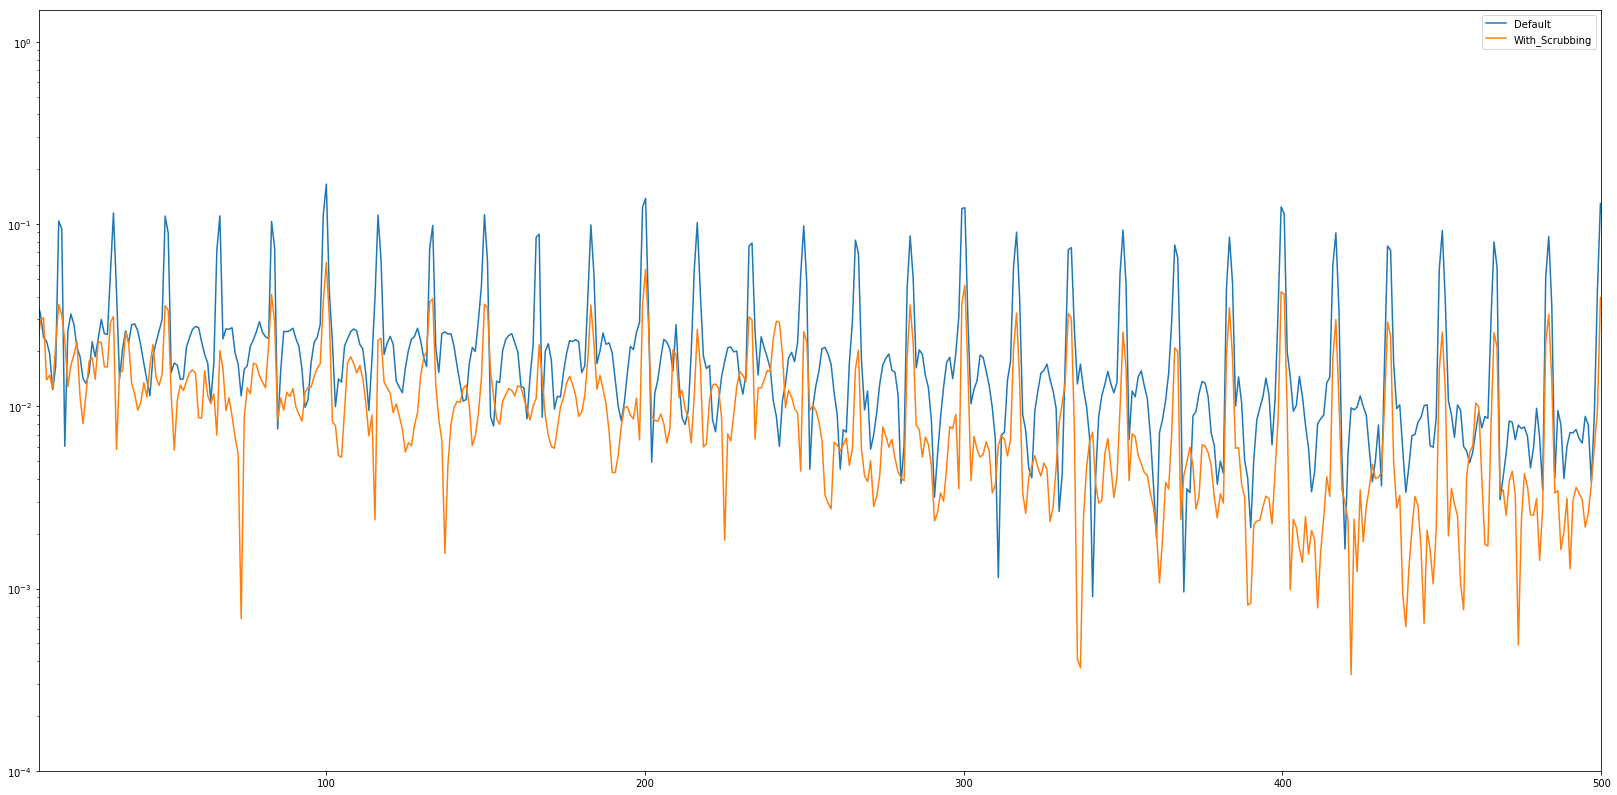

In [3]:
plot(["../DATA/FSW_3.2.0.15_STANDBY.csv.gz","../DATA/FSW_3.2.0.15_NO_PWD_STANDBY.csv.gz"],["Default","With_Scrubbing"])

## NORMAL mode

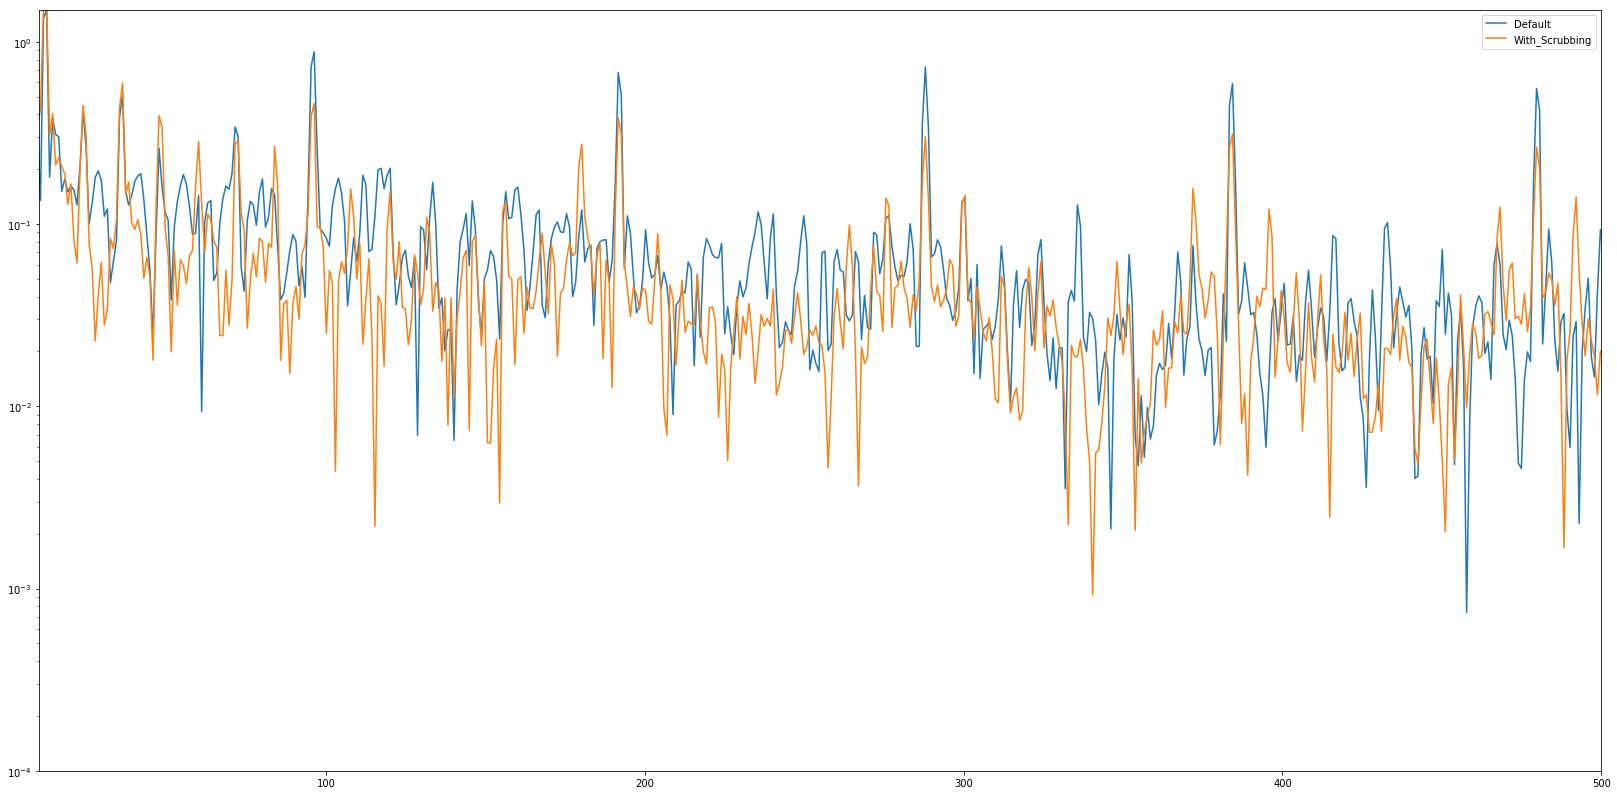

In [4]:
plot(["../DATA/FSW_3.2.0.15_NORMAL.csv.gz","../DATA/FSW_3.2.0.15_NO_PWD_NORMAL.csv.gz"],["Default","With_Scrubbing"])

## BURST mode

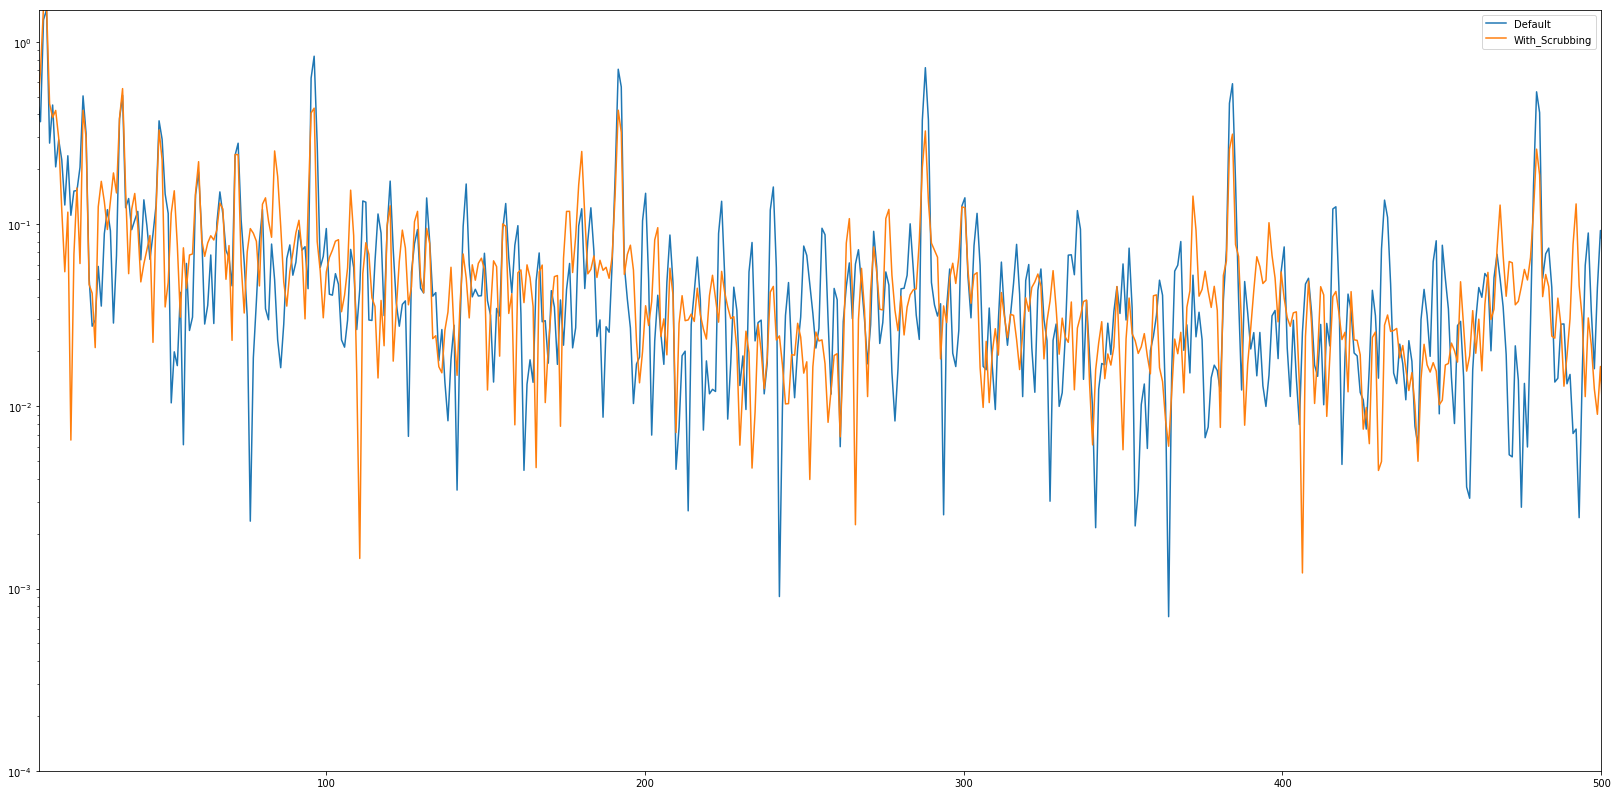

In [5]:
plot(["../DATA/FSW_3.2.0.15_BURST.csv.gz","../DATA/FSW_3.2.0.15_NO_PWD_BURST.csv.gz"],["Default","With_Scrubbing"])

## SBM1 mode

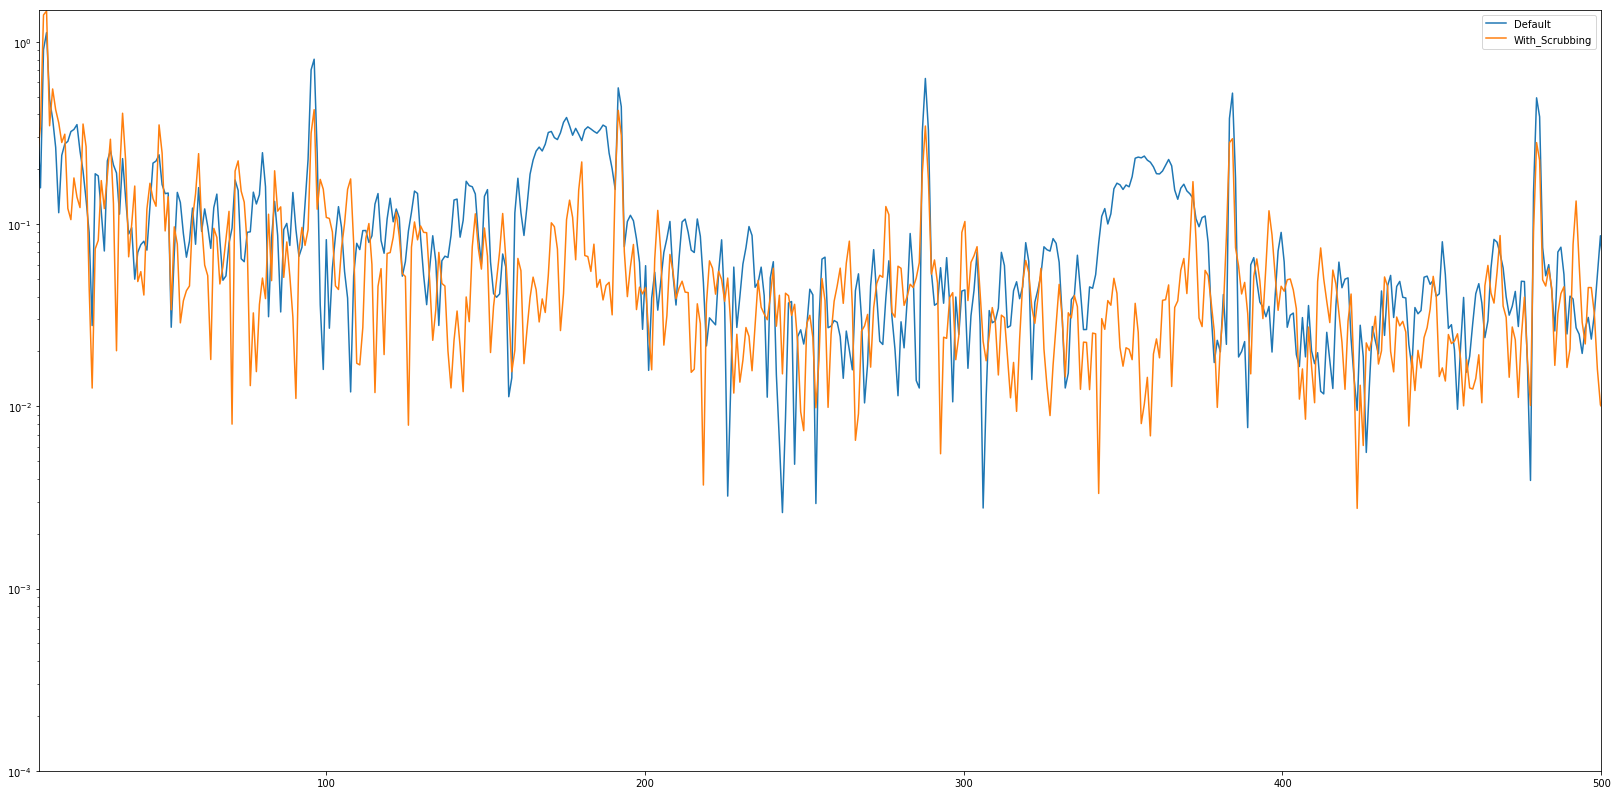

In [6]:
plot(["../DATA/FSW_3.2.0.15_SBM1.csv.gz","../DATA/FSW_3.2.0.15_NO_PWD_SBM1.csv.gz"],["Default","With_Scrubbing"])

## SBM2 mode

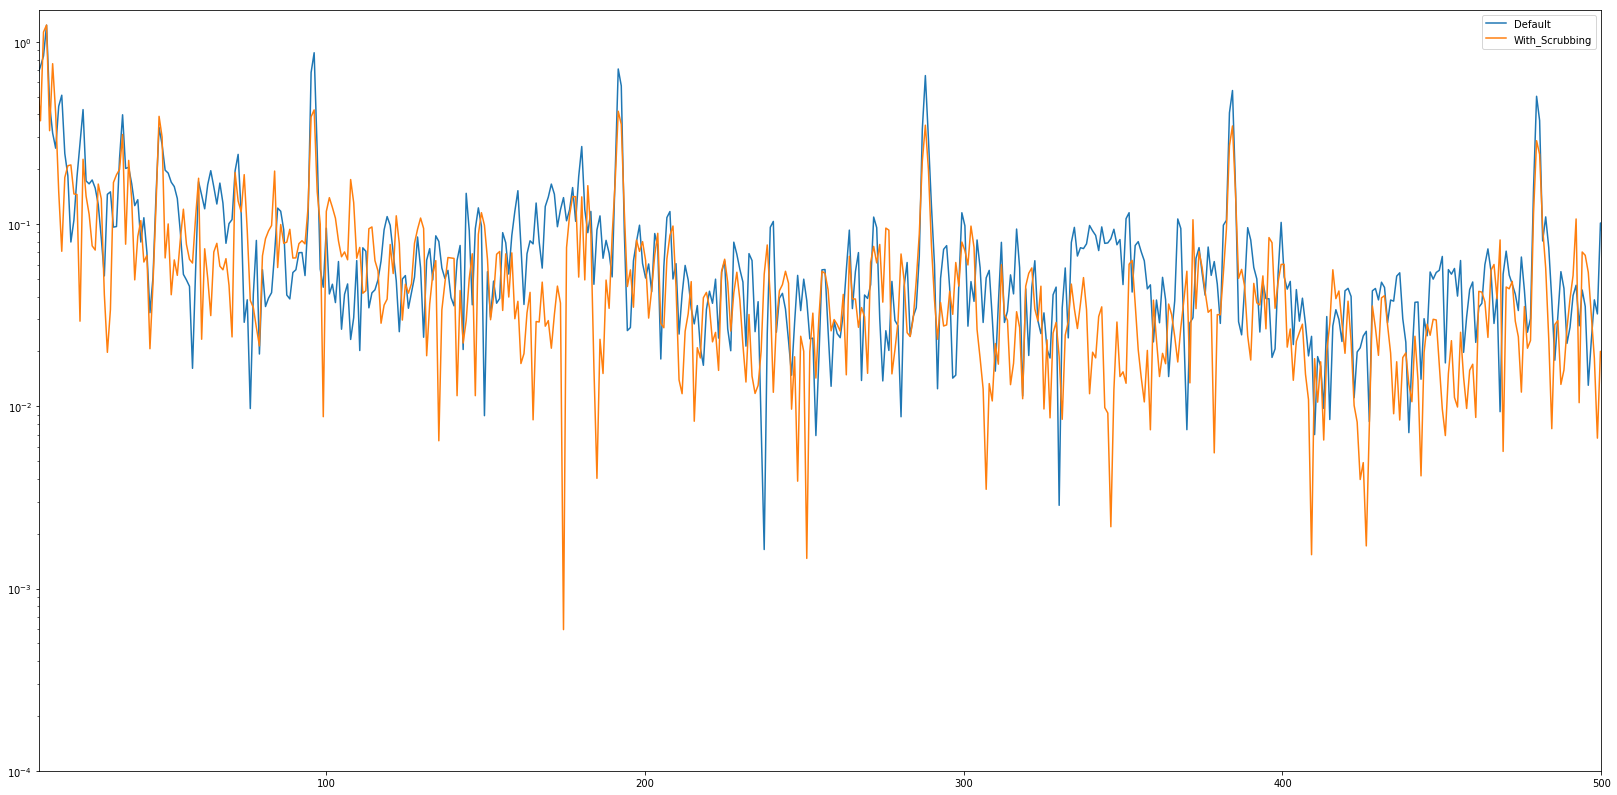

In [7]:
plot(["../DATA/FSW_3.2.0.15_SBM2.csv.gz","../DATA/FSW_3.2.0.15_NO_PWD_SBM2.csv.gz"],["Default","With_Scrubbing"])

# Modified FSW mode comparaison

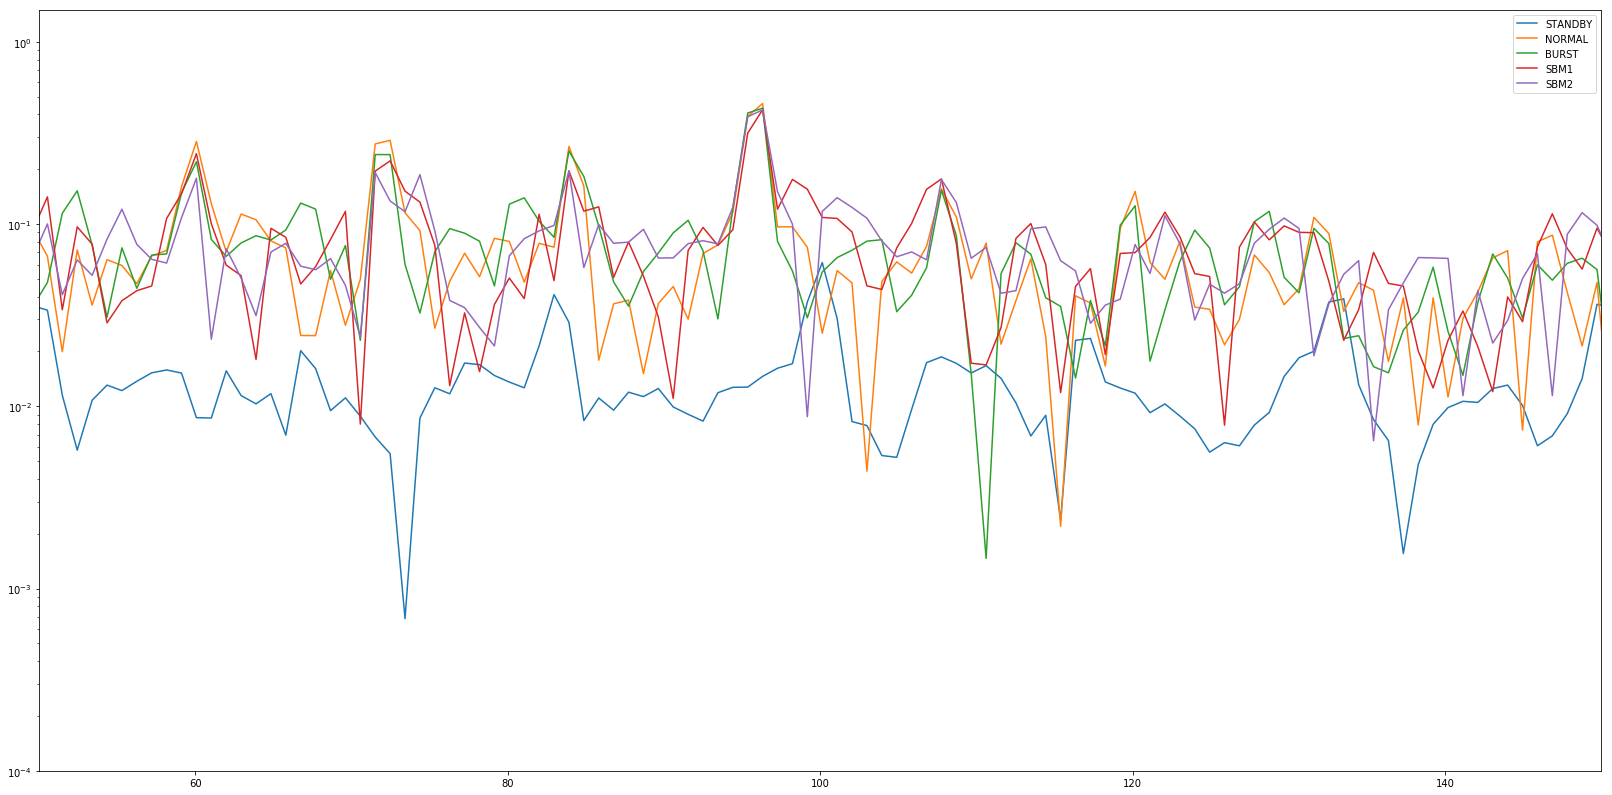

In [8]:
modes=["STANDBY","NORMAL","BURST","SBM1","SBM2"]
files=["../DATA/FSW_3.2.0.15_NO_PWD_{mode}.csv.gz".format(mode=mode) for mode in modes]
plot(files,modes,x_range=(5e1,1.5e2))

# Default FSW mode comparaison

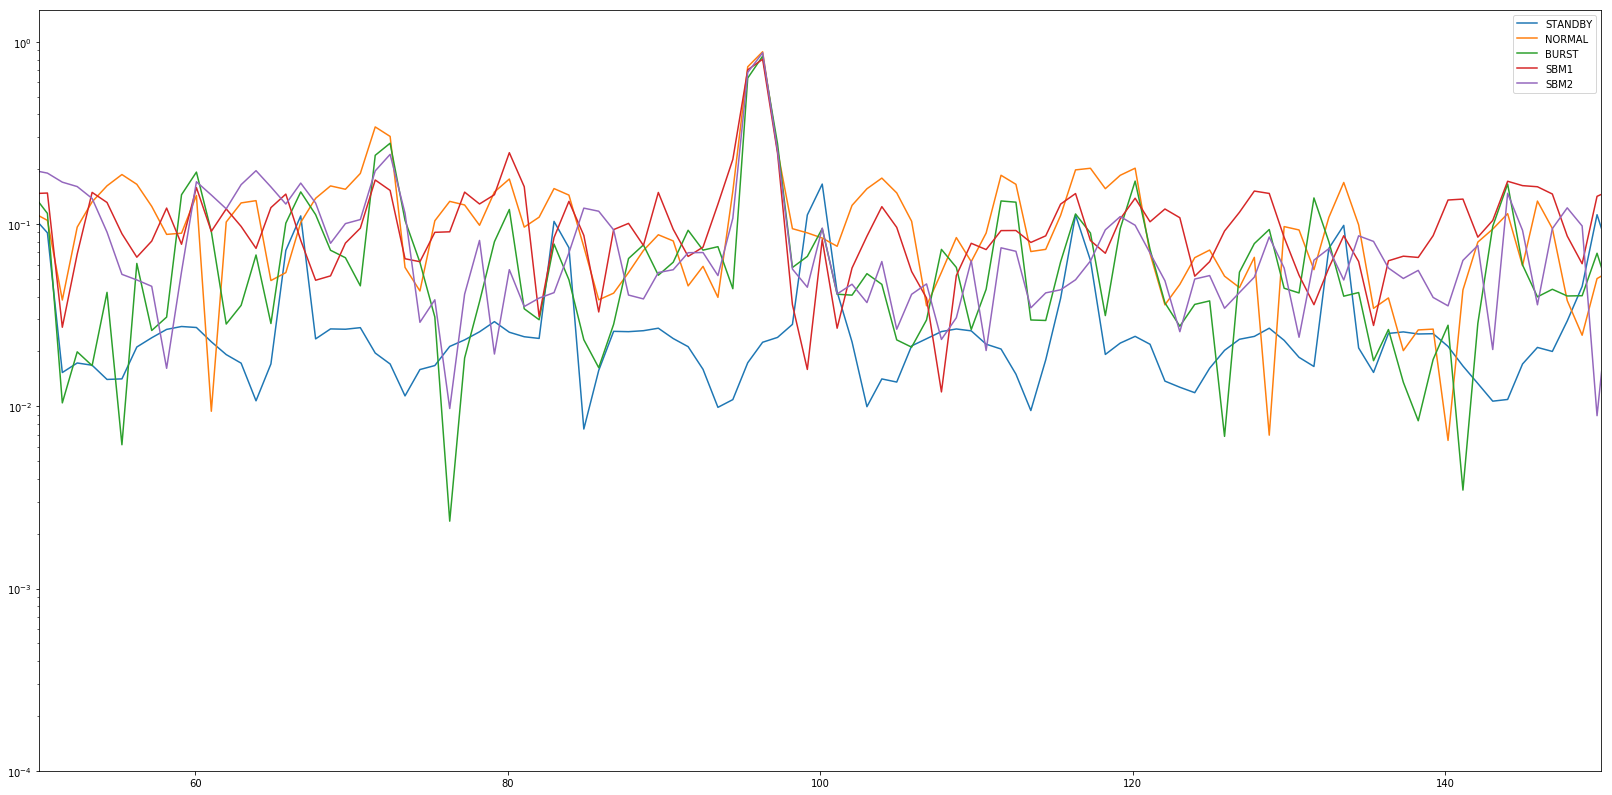

In [9]:
modes=["STANDBY","NORMAL","BURST","SBM1","SBM2"]
files=["../DATA/FSW_3.2.0.15_{mode}.csv.gz".format(mode=mode) for mode in modes]
plot(files,modes,x_range=(5e1,1.5e2))

# Conclusion

It is possible to reduce 96Hz emmision from LFR with a software modification, while this doesn't remove totaly the 96Hz pike this might be enough. It might also be possible to improve this result with more software modifications.